<a href="https://colab.research.google.com/github/Danil1D/KSVD/blob/main/%D0%94%D0%B0%D1%88%D0%BA%D0%B5%D0%B2%D0%B8%D1%87_%D0%9B%D0%B0%D0%B1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data source import complete.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 279MB/s]


Epoch 1/5, Train Loss: 2.2327, Val Loss: 0.9599, Train Acc: 0.5415, Val Acc: 0.7980
Epoch 2/5, Train Loss: 0.8882, Val Loss: 0.6188, Train Acc: 0.8069, Val Acc: 0.8480
Epoch 3/5, Train Loss: 0.6336, Val Loss: 0.4806, Train Acc: 0.8522, Val Acc: 0.8760
Epoch 4/5, Train Loss: 0.5117, Val Loss: 0.4424, Train Acc: 0.8803, Val Acc: 0.8880
Epoch 5/5, Train Loss: 0.4261, Val Loss: 0.4080, Train Acc: 0.9009, Val Acc: 0.8800


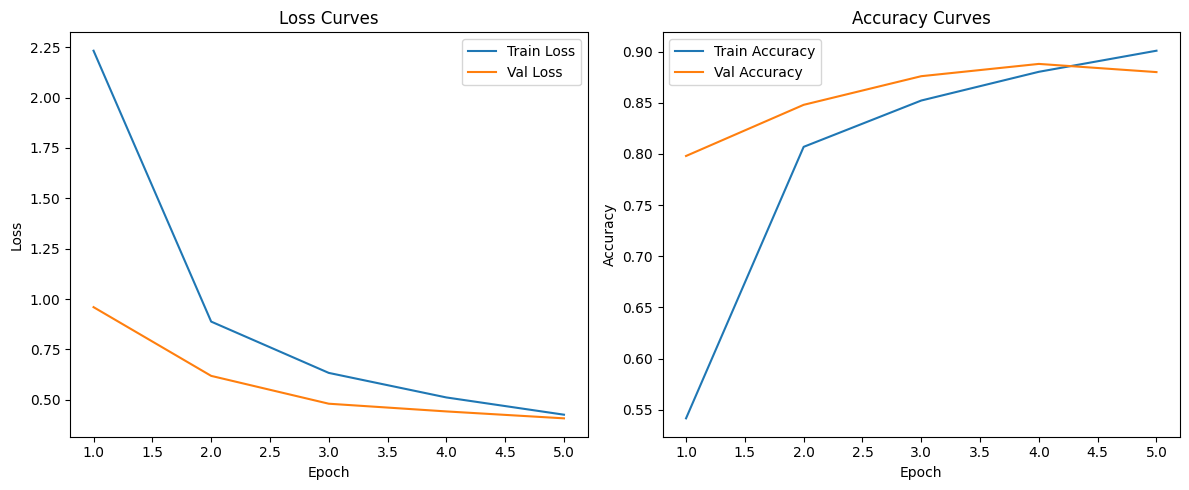

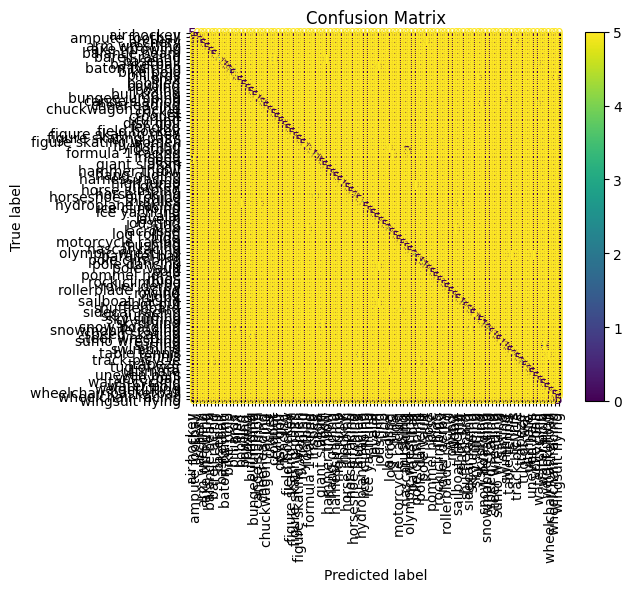

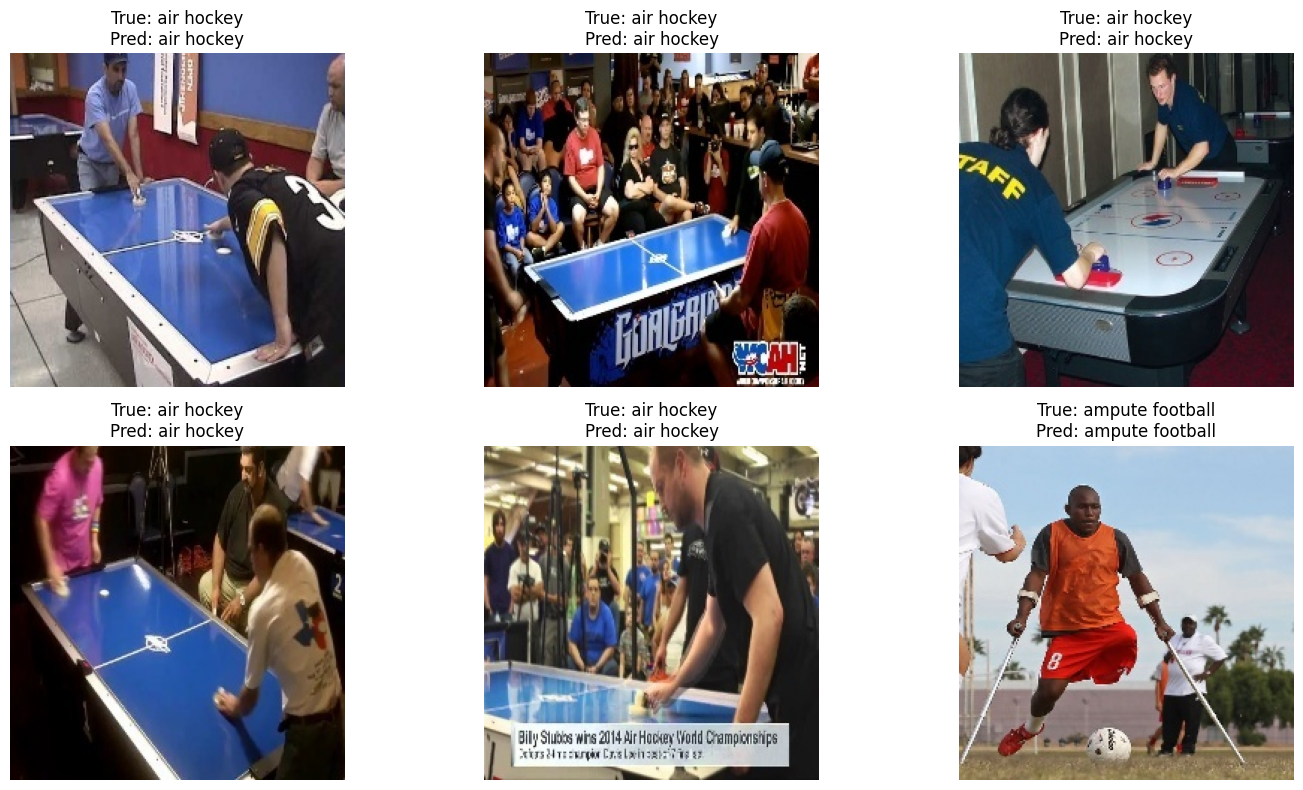

In [2]:
import kagglehub
gpiosenka_cards_image_datasetclassification_path = kagglehub.dataset_download('gpiosenka/sports-classification')

print('Data source import complete.')
# 📌 Імпорти
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# 📁 Шляхи
train_dir = '/kaggle/input/sports-classification/train'
val_dir = '/kaggle/input/sports-classification/valid'
test_dir = '/kaggle/input/sports-classification/test'

# 🔁 Трансформації
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 📦 Датасети
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

class_names = train_data.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Завантажуємо ResNet18
model = models.resnet18(pretrained=True)

# Заморожуємо всі шари
for param in model.parameters():
    param.requires_grad = False

# Змінюємо останній повнозв'язний шар
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# 🔧 Налаштування навчання
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# 🔁 Функція навчання
def train_model(model, train_loader, val_loader, epochs=5):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
    return train_loss, val_loss, train_acc, val_acc

# 🏋️ Навчання
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=5)

# 📈 Графіки навчання
epochs_range = range(1, 6)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

# 📊 Матриця плутанини
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate_model(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=90)
plt.title('Confusion Matrix')
plt.show()

# 🖼️ Випадкові передбачення
def visualize_predictions(model, loader, n=6):
    model.eval()
    shown = 0
    plt.figure(figsize=(15, 8))
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(inputs.size(0)):
                if shown >= n:
                    break
                plt.subplot(2, 3, shown + 1)
                img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                plt.imshow(img)
                plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
                plt.axis('off')
                shown += 1
            if shown >= n:
                break
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)
